In [10]:
# ============================================================
# House Price Prediction — Single End-to-End Kaggle Script (FIXED)
# - Loads Excel
# - Feature engineering (time features + property age + condition ordinal)
# - Label encodes: Location, Type
# - Imputes missing values (median)
# - Scales ONLY continuous numeric features (StandardScaler)
#   (Keeps label-encoded categoricals unscaled to avoid fake distances)
# - Shows first 5 rows AFTER preprocessing
# ============================================================

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

# -----------------------------
# 1) Load dataset (Kaggle path)
# -----------------------------
xlsx_path = "/kaggle/input/house-price-prediction/Case Study 1 Data.xlsx"
df = pd.read_excel(xlsx_path)

print("Original shape:", df.shape)
print("Original head:")
display(df.head())

# -----------------------------------------
# 2) Cleaning + feature engineering function
# -----------------------------------------
def prepare_df(raw: pd.DataFrame) -> pd.DataFrame:
    df = raw.copy()
    df.columns = [c.strip() for c in df.columns]

    # Drop rows where target is missing
    df = df.dropna(subset=["Price"]).reset_index(drop=True)

    # Parse date
    df["Date Sold"] = pd.to_datetime(df["Date Sold"], errors="coerce")

    # Time features
    df["Sold_Year"] = df["Date Sold"].dt.year
    df["Sold_Month"] = df["Date Sold"].dt.month
    df["Sold_Quarter"] = df["Date Sold"].dt.quarter

    # Property age (may create NaNs if Year Built or Sold_Year missing)
    df["Property_Age"] = df["Sold_Year"] - df["Year Built"]

    # Ordinal mapping for Condition
    cond_map = {"Poor": 0, "Fair": 1, "Good": 2, "New": 3}
    df["Condition_Ordinal"] = df["Condition"].map(cond_map)

    # Drop columns not used directly
    drop_cols = ["Property ID", "Condition", "Date Sold"]
    for c in drop_cols:
        if c in df.columns:
            df = df.drop(columns=[c])

    return df

df2 = prepare_df(df)

print("\nAfter feature engineering shape:", df2.shape)
print("After feature engineering head:")
display(df2.head())

# -----------------------------
# 3) Split features and target
# -----------------------------
y = df2["Price"].astype(float).copy()
X = df2.drop(columns=["Price"]).copy()

# ------------------------------------------------
# 4) Label encode categorical columns (Location, Type)
#    NOTE: We will NOT standard-scale these columns.
# ------------------------------------------------
label_encoders = {}
cat_cols = ["Location", "Type"]

for col in cat_cols:
    if col not in X.columns:
        raise ValueError(f"Expected categorical column '{col}' not found in X columns.")
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

print("\nLabel encoding mappings:")
for col, le in label_encoders.items():
    mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(f"{col}: {mapping}")

# ---------------------------------
# 5) Impute missing values (median)
# ---------------------------------
imputer = SimpleImputer(strategy="median")
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# ---------------------------------------------------------
# 6) Scale ONLY continuous numeric features (z-score)
#    Keep label-encoded categoricals untouched (0,1,2,...)
# ---------------------------------------------------------
num_cols_to_scale = [c for c in X_imputed.columns if c not in cat_cols]

scaler = StandardScaler()
X_scaled = X_imputed.copy()
X_scaled[num_cols_to_scale] = scaler.fit_transform(X_imputed[num_cols_to_scale])

# ----------------------------------------------
# 7) Show first 5 rows AFTER preprocessing
# ----------------------------------------------
print("\nFinal preprocessed shape:", X_scaled.shape)
print("First 5 rows AFTER preprocessing (label-encoded categoricals UNscaled + numeric scaled):")
display(X_scaled.head(5))

# ----------------------------------------------
# 8) Optional: log-transform target for training
# ----------------------------------------------
y_log = np.log1p(y)

print("\nTarget stats:")
print("Price (original) -> min/mean/max:", float(y.min()), float(y.mean()), float(y.max()))
print("Price (log1p)    -> min/mean/max:", float(y_log.min()), float(y_log.mean()), float(y_log.max()))


Original shape: (247172, 10)
Original head:


,Property ID,Location,Size,Bedrooms,Bathrooms,Year Built,Condition,Type,Date Sold,Price
0,SI_000001,CityA,3974.0,2.0,2.0,2007.0,Good,Single Family,2020-11-02,324000.0
1,SI_000002,CityA,1660.0,2.0,3.0,1934.0,Good,Single Family,2022-10-23,795000.0
2,SI_000003,CityC,2094.0,2.0,2.0,1950.0,Good,Single Family,2020-11-30,385000.0
3,SI_000004,CityB,1930.0,2.0,3.0,1905.0,Good,Single Family,2021-12-09,651000.0
4,SI_000005,CityB,1895.0,5.0,2.0,1936.0,New,Single Family,2024-10-30,1878000.0



After feature engineering shape: (241735, 12)
After feature engineering head:


,Location,Size,Bedrooms,Bathrooms,Year Built,Type,Price,Sold_Year,Sold_Month,Sold_Quarter,Property_Age,Condition_Ordinal
0,CityA,3974.0,2.0,2.0,2007.0,Single Family,324000.0,2020,11,4,13.0,2.0
1,CityA,1660.0,2.0,3.0,1934.0,Single Family,795000.0,2022,10,4,88.0,2.0
2,CityC,2094.0,2.0,2.0,1950.0,Single Family,385000.0,2020,11,4,70.0,2.0
3,CityB,1930.0,2.0,3.0,1905.0,Single Family,651000.0,2021,12,4,116.0,2.0
4,CityB,1895.0,5.0,2.0,1936.0,Single Family,1878000.0,2024,10,4,88.0,3.0



Label encoding mappings:
Location: {'CityA': np.int64(0), 'CityB': np.int64(1), 'CityC': np.int64(2), 'CityD': np.int64(3)}
Type: {'Condominium': np.int64(0), 'Single Family': np.int64(1), 'Townhouse': np.int64(2)}

Final preprocessed shape: (241735, 11)
First 5 rows AFTER preprocessing (label-encoded categoricals UNscaled + numeric scaled):


,Location,Size,Bedrooms,Bathrooms,Year Built,Type,Sold_Year,Sold_Month,Sold_Quarter,Property_Age,Condition_Ordinal
0,0.0,1.701963,-0.711367,-0.003448,1.294304,1.0,-1.413745,1.299310,1.336287,-1.350054,0.672091
1,0.0,-0.804114,-0.711367,1.224262,-0.778466,1.0,-0.000570,1.009179,1.336287,0.777834,0.672091
2,2.0,-0.334089,-0.711367,-0.003448,-0.324160,1.0,-1.413745,1.299310,1.336287,0.267141,0.672091
3,1.0,-0.511702,-0.711367,1.224262,-1.601895,1.0,-0.707158,1.589440,1.336287,1.572245,0.672091
4,1.0,-0.549607,1.421773,-0.003448,-0.721678,1.0,1.412605,1.009179,1.336287,0.777834,1.774346



Target stats:
Price (original) -> min/mean/max: 26000.0 466088.27848677273 2223000.0
Price (log1p)    -> min/mean/max: 10.165890277802454 12.939168225506185 14.614368642788788


Preprocessed feature shape: (241735, 11)


,Location,Size,Bedrooms,Bathrooms,Year Built,Type,Sold_Year,Sold_Month,Sold_Quarter,Property_Age,Condition_Ordinal
0,0.0,1.701963,-0.711367,-0.003448,1.294304,1.0,-1.413745,1.299310,1.336287,-1.350054,0.672091
1,0.0,-0.804114,-0.711367,1.224262,-0.778466,1.0,-0.000570,1.009179,1.336287,0.777834,0.672091
2,2.0,-0.334089,-0.711367,-0.003448,-0.324160,1.0,-1.413745,1.299310,1.336287,0.267141,0.672091
3,1.0,-0.511702,-0.711367,1.224262,-1.601895,1.0,-0.707158,1.589440,1.336287,1.572245,0.672091
4,1.0,-0.549607,1.421773,-0.003448,-0.721678,1.0,1.412605,1.009179,1.336287,0.777834,1.774346


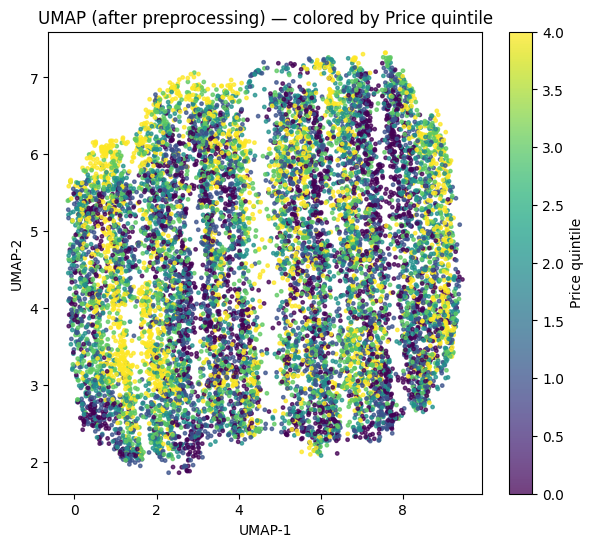

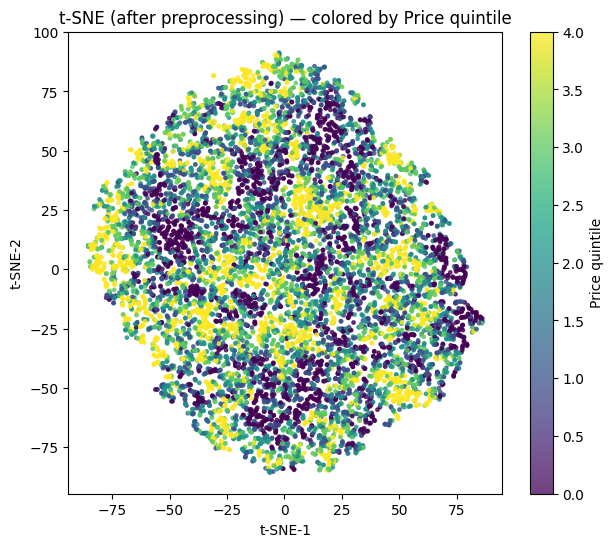

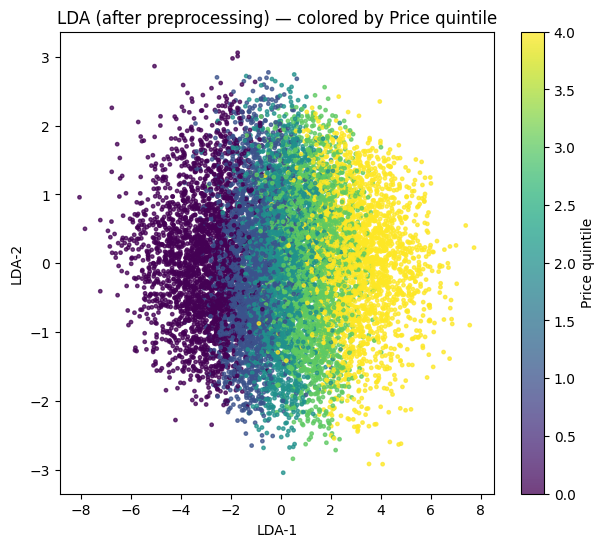

In [11]:
# ============================================================
# Visualization AFTER preprocessing: UMAP + t-SNE + LDA
# (Label-encoded categoricals kept unscaled; numeric scaled)
# ============================================================

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# UMAP: import or install if missing (Kaggle-safe)
try:
    import umap
except Exception:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "umap-learn"])
    import umap

# -----------------------------
# 1) Load dataset
# -----------------------------
xlsx_path = "/kaggle/input/house-price-prediction/Case Study 1 Data.xlsx"
df = pd.read_excel(xlsx_path)
df.columns = [c.strip() for c in df.columns]

# -----------------------------
# 2) Feature engineering
# -----------------------------
def prepare_df(raw: pd.DataFrame) -> pd.DataFrame:
    df = raw.copy()
    df.columns = [c.strip() for c in df.columns]

    df = df.dropna(subset=["Price"]).reset_index(drop=True)

    df["Date Sold"] = pd.to_datetime(df["Date Sold"], errors="coerce")
    df["Sold_Year"] = df["Date Sold"].dt.year
    df["Sold_Month"] = df["Date Sold"].dt.month
    df["Sold_Quarter"] = df["Date Sold"].dt.quarter

    df["Property_Age"] = df["Sold_Year"] - df["Year Built"]

    cond_map = {"Poor": 0, "Fair": 1, "Good": 2, "New": 3}
    df["Condition_Ordinal"] = df["Condition"].map(cond_map)

    drop_cols = ["Property ID", "Condition", "Date Sold"]
    for c in drop_cols:
        if c in df.columns:
            df.drop(columns=[c], inplace=True)

    return df

df2 = prepare_df(df)

y = df2["Price"].astype(float).values
X = df2.drop(columns=["Price"]).copy()

# -----------------------------
# 3) Label encode categoricals
# -----------------------------
cat_cols = ["Location", "Type"]
label_encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# -----------------------------
# 4) Impute + scale numeric only
# -----------------------------
imputer = SimpleImputer(strategy="median")
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

num_cols_to_scale = [c for c in X_imputed.columns if c not in cat_cols]
scaler = StandardScaler()
X_scaled = X_imputed.copy()
X_scaled[num_cols_to_scale] = scaler.fit_transform(X_imputed[num_cols_to_scale])

print("Preprocessed feature shape:", X_scaled.shape)
display(X_scaled.head(5))

# -----------------------------
# 5) Subsample for visualization
# -----------------------------
N_SAMPLE = 12000  # adjust up/down for speed
rng = np.random.default_rng(42)
idx = rng.choice(len(X_scaled), size=min(N_SAMPLE, len(X_scaled)), replace=False)

X_vis = X_scaled.iloc[idx].values
y_vis = y[idx]

# For coloring: convert continuous price -> discrete bins
# (Needed for LDA; also makes plots interpretable)
y_bins = pd.qcut(y_vis, q=5, labels=False, duplicates="drop")

# -----------------------------
# 6) UMAP
# -----------------------------
umap_model = umap.UMAP(
    n_neighbors=30,
    min_dist=0.1,
    n_components=2,
    random_state=42
)
Z_umap = umap_model.fit_transform(X_vis)

plt.figure(figsize=(7,6))
plt.scatter(Z_umap[:,0], Z_umap[:,1], c=y_bins, s=6, alpha=0.75)
plt.title("UMAP (after preprocessing) — colored by Price quintile")
plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2")
plt.colorbar(label="Price quintile")
plt.show()

# -----------------------------
# 7) t-SNE (slower)
# -----------------------------
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate="auto",
    init="pca",
    random_state=42
)
Z_tsne = tsne.fit_transform(X_vis)

plt.figure(figsize=(7,6))
plt.scatter(Z_tsne[:,0], Z_tsne[:,1], c=y_bins, s=6, alpha=0.75)
plt.title("t-SNE (after preprocessing) — colored by Price quintile")
plt.xlabel("t-SNE-1"); plt.ylabel("t-SNE-2")
plt.colorbar(label="Price quintile")
plt.show()

# -----------------------------
# 8) LDA (supervised projection)
#     n_components <= (n_classes - 1)
# -----------------------------
n_classes = int(pd.Series(y_bins).nunique())
lda_components = min(2, n_classes - 1)  # typically 2 for 5 bins

lda = LDA(n_components=lda_components)
Z_lda = lda.fit_transform(X_vis, y_bins)

plt.figure(figsize=(7,6))
if Z_lda.shape[1] == 1:
    # if only 1 component possible, plot against zeros
    plt.scatter(Z_lda[:,0], np.zeros_like(Z_lda[:,0]), c=y_bins, s=6, alpha=0.75)
    plt.xlabel("LDA-1"); plt.ylabel("0")
else:
    plt.scatter(Z_lda[:,0], Z_lda[:,1], c=y_bins, s=6, alpha=0.75)
    plt.xlabel("LDA-1"); plt.ylabel("LDA-2")

plt.title("LDA (after preprocessing) — colored by Price quintile")
plt.colorbar(label="Price quintile")
plt.show()


In [13]:
# ============================================================
# Model Zoo: 5-Fold CV + Comparison Table (No CLI) — FIXED
# - Handles sklearn versions where mean_squared_error has no squared=
# ============================================================

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor

# Optional: XGB/LGBM/CatBoost (install if missing)
import sys, subprocess

try:
    from xgboost import XGBRegressor
except Exception:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "xgboost"])
    from xgboost import XGBRegressor

try:
    from lightgbm import LGBMRegressor
except Exception:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "lightgbm"])
    from lightgbm import LGBMRegressor

try:
    from catboost import CatBoostRegressor
except Exception:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "catboost"])
    from catboost import CatBoostRegressor

# -----------------------------
# 1) Load + feature engineering
# -----------------------------
xlsx_path = "/kaggle/input/house-price-prediction/Case Study 1 Data.xlsx"
df = pd.read_excel(xlsx_path)
df.columns = [c.strip() for c in df.columns]

def prepare_df(raw: pd.DataFrame) -> pd.DataFrame:
    df = raw.copy()
    df.columns = [c.strip() for c in df.columns]

    df = df.dropna(subset=["Price"]).reset_index(drop=True)

    df["Date Sold"] = pd.to_datetime(df["Date Sold"], errors="coerce")
    df["Sold_Year"] = df["Date Sold"].dt.year
    df["Sold_Month"] = df["Date Sold"].dt.month
    df["Sold_Quarter"] = df["Date Sold"].dt.quarter

    df["Property_Age"] = df["Sold_Year"] - df["Year Built"]

    cond_map = {"Poor": 0, "Fair": 1, "Good": 2, "New": 3}
    df["Condition_Ordinal"] = df["Condition"].map(cond_map)

    drop_cols = ["Property ID", "Condition", "Date Sold"]
    for c in drop_cols:
        if c in df.columns:
            df.drop(columns=[c], inplace=True)

    return df

df2 = prepare_df(df)

y = df2["Price"].astype(float).values
y_log = np.log1p(y)

X = df2.drop(columns=["Price"]).copy()

# -----------------------------
# 2) Label encode Location/Type (global, safe)
# -----------------------------
cat_cols = ["Location", "Type"]
label_encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# Numeric columns to scale (do NOT scale label-encoded categoricals)
num_cols_to_scale = [c for c in X.columns if c not in cat_cols]
X = X.reset_index(drop=True)

# -----------------------------
# 3) Fold-wise preprocessing helper (NO leakage)
# -----------------------------
def fit_transform_fold(X_train: pd.DataFrame, X_valid: pd.DataFrame):
    # Impute on train
    imputer = SimpleImputer(strategy="median")
    Xtr = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
    Xva = pd.DataFrame(imputer.transform(X_valid), columns=X_valid.columns)

    # Scale numeric only on train
    scaler = StandardScaler()
    Xtr_scaled = Xtr.copy()
    Xva_scaled = Xva.copy()

    Xtr_scaled[num_cols_to_scale] = scaler.fit_transform(Xtr[num_cols_to_scale])
    Xva_scaled[num_cols_to_scale] = scaler.transform(Xva[num_cols_to_scale])

    return Xtr_scaled.values, Xva_scaled.values

# -----------------------------
# 4) Metrics (version-safe RMSE)
# -----------------------------
def eval_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)   # no squared= argument
    rmse = float(np.sqrt(mse))
    mae  = float(mean_absolute_error(y_true, y_pred))
    r2   = float(r2_score(y_true, y_pred))
    return rmse, mae, r2

# -----------------------------
# 5) Model zoo
# -----------------------------
models = {
    "Ridge": Ridge(alpha=1.0, random_state=42),
    "Lasso": Lasso(alpha=1e-4, random_state=42, max_iter=5000),
    "ElasticNet": ElasticNet(alpha=1e-4, l1_ratio=0.5, random_state=42, max_iter=5000),

    "RandomForest": RandomForestRegressor(
        n_estimators=400, random_state=42, n_jobs=-1
    ),

    "HistGBDT": HistGradientBoostingRegressor(
        random_state=42, learning_rate=0.05, max_iter=500
    ),

    "XGBoost": XGBRegressor(
        n_estimators=1200,
        learning_rate=0.03,
        max_depth=6,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1
    ),

    "LightGBM": LGBMRegressor(
        n_estimators=3000,
        learning_rate=0.02,
        num_leaves=64,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1
    ),

    "CatBoost": CatBoostRegressor(
        iterations=4000,
        learning_rate=0.03,
        depth=8,
        loss_function="RMSE",
        random_seed=42,
        verbose=False
    )
}

# -----------------------------
# 6) 5-fold CV loop
# -----------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)

rows = []

for name, model in models.items():
    fold_scores = []

    for fold, (tr_idx, va_idx) in enumerate(kf.split(X), start=1):
        X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
        y_tr_log, y_va = y_log[tr_idx], y[va_idx]

        Xtr_np, Xva_np = fit_transform_fold(X_tr, X_va)

        model.fit(Xtr_np, y_tr_log)

        pred_log = model.predict(Xva_np)
        pred = np.expm1(pred_log)

        rmse, mae, r2 = eval_metrics(y_va, pred)
        fold_scores.append((rmse, mae, r2))

        print(f"{name:12s} | Fold {fold} | RMSE={rmse:,.2f}  MAE={mae:,.2f}  R2={r2:.4f}")

    fold_scores = np.array(fold_scores)
    rmse_mean, mae_mean, r2_mean = fold_scores.mean(axis=0)
    rmse_std,  mae_std,  r2_std  = fold_scores.std(axis=0)

    rows.append({
        "Model": name,
        "RMSE_mean": rmse_mean, "RMSE_std": rmse_std,
        "MAE_mean": mae_mean,   "MAE_std": mae_std,
        "R2_mean": r2_mean,     "R2_std": r2_std
    })

results_df = pd.DataFrame(rows).sort_values("RMSE_mean").reset_index(drop=True)

# Pretty table
pretty = results_df.copy()
pretty["RMSE"] = pretty.apply(lambda r: f"{r['RMSE_mean']:.2f} ± {r['RMSE_std']:.2f}", axis=1)
pretty["MAE"]  = pretty.apply(lambda r: f"{r['MAE_mean']:.2f} ± {r['MAE_std']:.2f}", axis=1)
pretty["R2"]   = pretty.apply(lambda r: f"{r['R2_mean']:.4f} ± {r['R2_std']:.4f}", axis=1)

pretty = pretty[["Model", "RMSE", "MAE", "R2"]]
print("\n===== Model Zoo (5-Fold CV) Comparison =====")
display(pretty)


Ridge        | Fold 1 | RMSE=93,833.99  MAE=62,263.88  R2=0.8334
Ridge        | Fold 2 | RMSE=94,097.31  MAE=62,862.47  R2=0.8341
Ridge        | Fold 3 | RMSE=94,876.28  MAE=62,766.45  R2=0.8335
Ridge        | Fold 4 | RMSE=95,358.19  MAE=62,846.69  R2=0.8315
Ridge        | Fold 5 | RMSE=94,783.61  MAE=62,924.64  R2=0.8327
Lasso        | Fold 1 | RMSE=93,822.63  MAE=62,252.00  R2=0.8334
Lasso        | Fold 2 | RMSE=94,090.12  MAE=62,851.99  R2=0.8341
Lasso        | Fold 3 | RMSE=94,874.83  MAE=62,756.90  R2=0.8335
Lasso        | Fold 4 | RMSE=95,339.94  MAE=62,835.02  R2=0.8316
Lasso        | Fold 5 | RMSE=94,783.13  MAE=62,915.79  R2=0.8327
ElasticNet   | Fold 1 | RMSE=93,825.15  MAE=62,256.95  R2=0.8334
ElasticNet   | Fold 2 | RMSE=94,094.47  MAE=62,857.11  R2=0.8341
ElasticNet   | Fold 3 | RMSE=94,877.80  MAE=62,761.79  R2=0.8335
ElasticNet   | Fold 4 | RMSE=95,342.33  MAE=62,839.67  R2=0.8316
ElasticNet   | Fold 5 | RMSE=94,786.92  MAE=62,920.76  R2=0.8327
RandomForest | Fold 1 | R

,Model,RMSE,MAE,R2
0,CatBoost,27859.30 ± 346.56,18164.83 ± 84.96,0.9855 ± 0.0005
1,XGBoost,28099.84 ± 324.79,18480.88 ± 87.03,0.9853 ± 0.0004
2,LightGBM,28408.19 ± 334.38,18598.18 ± 70.39,0.9849 ± 0.0004
3,HistGBDT,28717.69 ± 245.69,19022.55 ± 33.14,0.9846 ± 0.0003
4,RandomForest,34161.14 ± 465.47,23223.29 ± 195.87,0.9782 ± 0.0007
5,Lasso,94582.13 ± 551.23,62722.34 ± 240.56,0.8331 ± 0.0009
6,ElasticNet,94585.33 ± 551.01,62727.26 ± 240.55,0.8331 ± 0.0009
7,Ridge,94589.88 ± 552.06,62732.82 ± 239.84,0.8330 ± 0.0009


## Final Model - CatBoost

In [14]:
# ============================================================
# Final CatBoost Training on FULL dataset
# ============================================================

import numpy as np
import pandas as pd
import joblib

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error

from catboost import CatBoostRegressor

# -----------------------------
# Load + feature engineering
# -----------------------------
xlsx_path = "/kaggle/input/house-price-prediction/Case Study 1 Data.xlsx"
df = pd.read_excel(xlsx_path)
df.columns = [c.strip() for c in df.columns]

def prepare_df(raw):
    df = raw.copy()
    df = df.dropna(subset=["Price"]).reset_index(drop=True)

    df["Date Sold"] = pd.to_datetime(df["Date Sold"], errors="coerce")
    df["Sold_Year"] = df["Date Sold"].dt.year
    df["Sold_Month"] = df["Date Sold"].dt.month
    df["Sold_Quarter"] = df["Date Sold"].dt.quarter
    df["Property_Age"] = df["Sold_Year"] - df["Year Built"]

    cond_map = {"Poor": 0, "Fair": 1, "Good": 2, "New": 3}
    df["Condition_Ordinal"] = df["Condition"].map(cond_map)

    df.drop(columns=["Property ID", "Condition", "Date Sold"], inplace=True)
    return df

df2 = prepare_df(df)

y = df2["Price"].values
y_log = np.log1p(y)

X = df2.drop(columns=["Price"]).copy()

# -----------------------------
# Label encode categoricals
# -----------------------------
cat_cols = ["Location", "Type"]
label_encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# -----------------------------
# Impute + scale numeric only
# -----------------------------
num_cols = [c for c in X.columns if c not in cat_cols]

imputer = SimpleImputer(strategy="median")
X_imp = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

scaler = StandardScaler()
X_imp[num_cols] = scaler.fit_transform(X_imp[num_cols])

# -----------------------------
# Train final CatBoost
# -----------------------------
final_model = CatBoostRegressor(
    iterations=4000,
    learning_rate=0.03,
    depth=8,
    loss_function="RMSE",
    random_seed=42,
    verbose=False
)

final_model.fit(X_imp, y_log)

# -----------------------------
# Final MAE (training set, sanity check)
# -----------------------------
pred_log = final_model.predict(X_imp)
pred = np.expm1(pred_log)

mae = mean_absolute_error(y, pred)
print(f"Final Training MAE: {mae:,.2f}")


Final Training MAE: 17,132.52


In [17]:
# ============================================================
# Save artifacts
# ============================================================

joblib.dump(final_model, "catboost_model.pkl")
joblib.dump(label_encoders, "label_encoders.pkl")
joblib.dump(imputer, "imputer.pkl")
joblib.dump(scaler, "scaler.pkl")

print("All artifacts saved successfully.")


All artifacts saved successfully.


,Feature,Importance
1,Size,25.409946
6,Sold_Year,22.536553
10,Condition_Ordinal,21.951295
0,Location,18.616513
2,Bedrooms,4.851655
5,Type,3.617691
7,Sold_Month,1.100916
3,Bathrooms,0.648340
8,Sold_Quarter,0.607965
9,Property_Age,0.336687


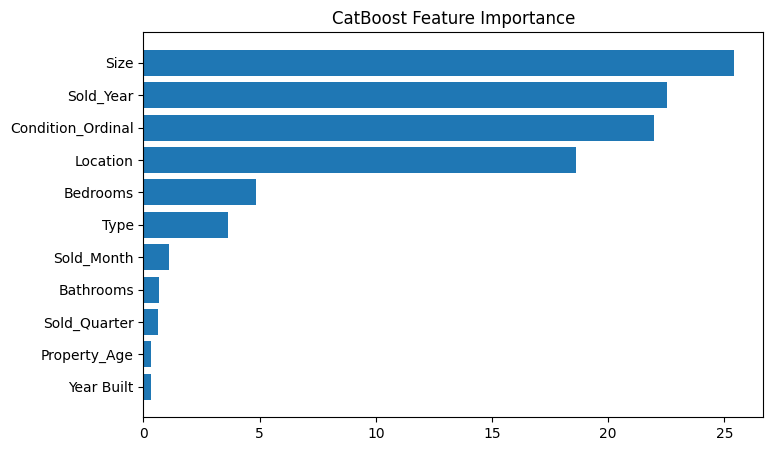

In [18]:
# ============================================================
# Feature Importance (CatBoost native)
# ============================================================

import matplotlib.pyplot as plt

feature_importance = final_model.get_feature_importance()
features = X_imp.columns

fi = pd.DataFrame({
    "Feature": features,
    "Importance": feature_importance
}).sort_values("Importance", ascending=False)

display(fi)

plt.figure(figsize=(8,5))
plt.barh(fi["Feature"], fi["Importance"])
plt.gca().invert_yaxis()
plt.title("CatBoost Feature Importance")
plt.show()


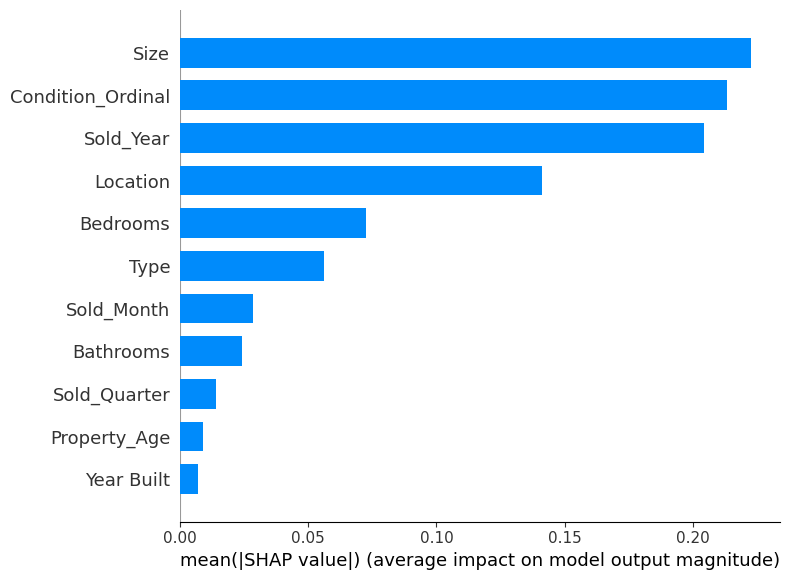

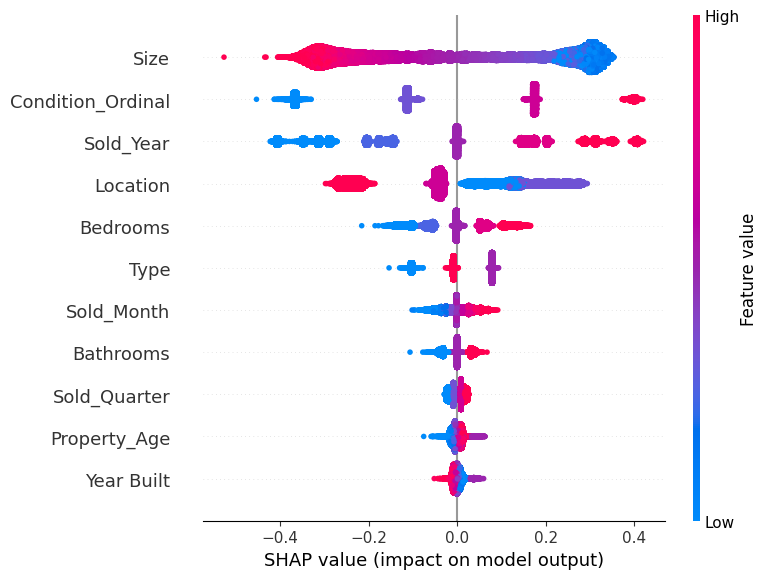

In [19]:
# ============================================================
# SHAP analysis
# ============================================================

import shap

explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_imp)

# Global importance
shap.summary_plot(shap_values, X_imp, plot_type="bar")

# Detailed distribution
shap.summary_plot(shap_values, X_imp)


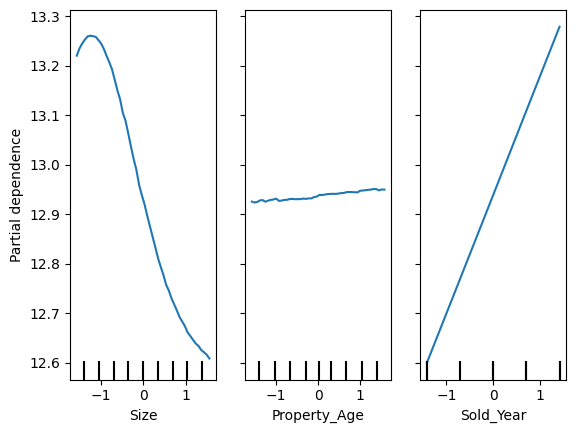

In [22]:
# ============================================================
# Partial Dependence Plots
# ============================================================

from sklearn.inspection import PartialDependenceDisplay

features_to_plot = [
    "Size",
    "Property_Age",
    "Sold_Year"
]

PartialDependenceDisplay.from_estimator(
    final_model,
    X_imp,
    features=features_to_plot,
    kind="average",
    grid_resolution=50
)
plt.show()
